# Measurement Correction

* **Last Updated:** Feb 20, 2019
* **Requires:** qiskit-terra 0.7

The idea behind measurement correction is to prepare all 2^n basis states and measure the probability of measuring counts in the other basis states. From these calibrations we can correct the average results of other experiment.

In [1]:
# Needed for functions
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Measurement correction functions
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
import qiskit.ignis.measurement_correction as meas_corr

## 3 Qubit Example of the Calibration Matrices

Here we will generate a calibration matrix for 3 qubits in a 5 qubit sample

In [2]:
#generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qi])

In [3]:
#generate the calibration circuits
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = meas_corr.measurement_calibration([qr[2],qr[3],qr[4]])

In [4]:
#run the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
qobj = qiskit.compile(meas_calibs, backend=backend, shots=1000)
job = backend.run(qobj, noise_model=noise_model)
cal_results = job.result()

In [5]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [6]:
#make a calibration matrix
MeasCal = meas_corr.MeasurementFitter(cal_results,state_labels)
print(MeasCal.cal_matrix)

[[0.428 0.052 0.068 0.001 0.068 0.007 0.007 0.   ]
 [0.132 0.502 0.018 0.076 0.013 0.066 0.003 0.011]
 [0.157 0.014 0.488 0.065 0.021 0.001 0.069 0.009]
 [0.042 0.179 0.17  0.632 0.006 0.021 0.019 0.085]
 [0.129 0.026 0.022 0.002 0.503 0.069 0.065 0.011]
 [0.045 0.17  0.003 0.021 0.166 0.607 0.021 0.078]
 [0.047 0.003 0.18  0.022 0.17  0.022 0.589 0.09 ]
 [0.02  0.054 0.051 0.181 0.053 0.207 0.227 0.716]]


## Correct Measurement Noise on a 3Q GHZ State

In [7]:
#make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

qobj = qiskit.compile([ghz], backend=backend, shots=5000)
job = backend.run(qobj, noise_model=noise_model)
results = job.result()

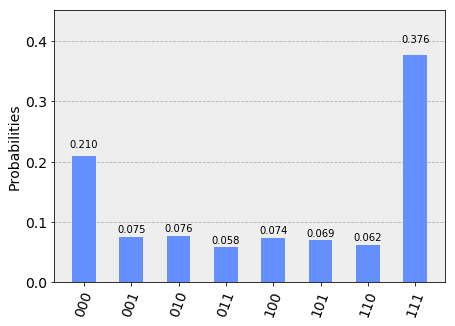

In [8]:
#results without correction
plot_histogram(results.get_counts(0))

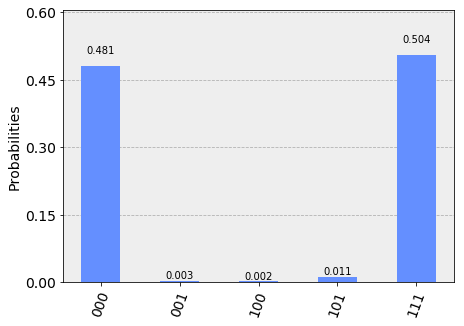

In [9]:
#results with correction
plot_histogram(MeasCal.calibrate(results.get_counts(0), method=1))